In [72]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

from semantic_loss.src.symbolic.symbolic import *

module_path = os.path.abspath(os.path.join(os.getcwd(), '../dl2/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from semantic_loss.src.experiment.synthetic_experiments import *
from semantic_loss.src.experiment.generative import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch as th
import torch.nn as nn
from torch.nn import functional as F
from models import *

import dl2lib as dl2

In [ ]:
INOUT_IDX = [
    [[0, 4], [8, 9]],   # s1->j1 + s2->j1 = 0 OR j1->p1 + j1->p2      act[0] = flow_s1_j1, act[4] = flow_s2_j1, etc...
    [[1, 5], [10, 11]],
    [[2, 6], [12, 13]],
    [[3, 7], [14, 15]],
]

EPS = 1e-2

In [ ]:
class ConstrainedIL_MLP_simple(nn.Module):
    def __init__(self, terms, dims = [128,128], act_cls = nn.ReLU, *args, **kwargs) -> None:
        super().__init__()
        

        self.N_BLEND = 4
        self.IN_DIM, self.OUT_DIM = 37, 20
        
        self.nterms = 2
        self.logic = OrList(
            terms=[Zero() for i in range(len(INOUT_IDX))]
        )

        layers = []
        dims = [self.IN_DIM] + dims + [self.OUT_DIM + (self.nterms * self.N_BLEND)]
        
        for k in range(len(dims)-1):
            layers.append(nn.Linear(in_features = dims[k], out_features = dims[k+1]))
            layers.append(act_cls())
        
        self.model_pi = nn.Sequential(*layers)
    
    def forward(self, x):
        uc_act: th.Tensor = self.model_pi(x)
        
        act, L_dec = uc_act.split(self.OUT_DIM, self.nterms * self.N_BLEND, dim=1)
        v1, v2, v3, v4 = L_dec.split(self.N_BLEND, dim=1)
        
        return act, v1, v2, v3, v4
        
        

In [ ]:
class ConstrainedSimpleExperiment(BaseSyntheticExperiment):
    def __init__(self, name: str = "Simple", inout_idx = INOUT_IDX, **kwargs):
        super().__init__(name=name, **kwargs)
        self.inout_idx = inout_idx
    
    @property
    def logic_terms(self):
        terms = []
        for in_, out_ in self.inout_idx:
            
        
        return terms
    
    def create_model(self):
        ...
        
    def criterion(self, output, target):
        ...

In [43]:
np.random.choice(np.arange(3),replace=True, size=5)

array([2, 1, 0, 2, 0])

In [17]:
np.arange(2)

array([0, 1])

In [97]:
mu, log_var = th.tensor([10]*5), th.tensor([-1]*5)
std = torch.exp(0.5 * log_var)
eps = torch.randn_like(std)
sample = mu + (eps * std)
sample

tensor([10.0482, 10.8346,  9.2499,  9.8754, 10.8276])

In [113]:
# GEQ
threshold_lower = 5.5
threshold_upper = 7.2
split1, split2 = th.tensor([-50, 0, 20, 50, 100], dtype=th.float32), th.tensor([-50, 0, 20, 50, 100])

restricted1 = F.softplus(split1) + threshold_upper
restricted2 = torch.ones_like(split2) * threshold_lower

restricted1, restricted2

(tensor([  7.2000,   7.8931,  27.2000,  57.2000, 107.2000]),
 tensor([5.5000, 5.5000, 5.5000, 5.5000, 5.5000]))

In [114]:
# Between
threshold_upper=[-1.0, 1.0]
threshold_lower = 5.5
greater_than = (F.softplus(
        split1 - threshold_upper[0]) + threshold_upper[0]
)
less_than = (-F.softplus(-greater_than + threshold_upper[1]) + threshold_upper[1]
)

restricted2 = - F.softplus(-split2 + threshold_lower) + threshold_lower

less_than, restricted2

(tensor([-1.1269, -0.0943,  1.0000,  1.0000,  1.0000]),
 tensor([-5.0000e+01, -4.0784e-03,  5.5000e+00,  5.5000e+00,  5.5000e+00]))

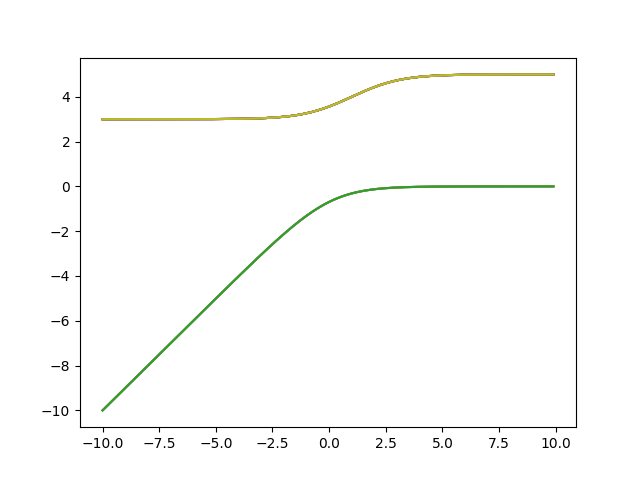

In [195]:
# Visualizing the transformation in "Between"
a = 3
b = 5
import PIL

# def f(x):
#     return(-F.softplus(-F.softplus(x) + np.log(np.exp(b-a) - 1)) + b)

def g(x):
    return(-F.softplus(-x))

x = np.arange(-10, 10, 0.1)
y = np.array([g(th.Tensor([t])).item() for t in x])
plt.plot(x,y)
plt.savefig("a.png")
PIL.Image.open("a.png")

In [126]:
def all_predictions(layers, x):
    return torch.stack([f(x) for f in layers], dim=1)

In [128]:
c = nn.Linear(8, 3)
d = [nn.Linear(3,2) for _ in range(4)]
x = th.ones((10,8))
y = c(x)
z = all_predictions(d, y)

In [129]:
y.shape

torch.Size([10, 3])

In [131]:
z.shape, z[0]

(torch.Size([10, 4, 2]),
 tensor([[-0.4793, -0.0209],
         [ 0.0918, -0.1816],
         [ 0.2909, -0.0802],
         [ 0.3467, -0.2130]], grad_fn=<SelectBackward0>))

In [136]:
zz = z.split(1, dim=1)
len(zz), zz[0].squeeze(1).shape

(4, torch.Size([10, 2]))

In [186]:
ll = []
target = th.rand((10,2))
for _, p in enumerate(zz):
    ll += [
        10.0 * F.mse_loss(p.squeeze(1), target, reduction="none").sum(dim=1)
    ]
ll

[tensor([ 9.4654,  6.6831,  7.1011, 18.6726, 15.5193, 19.6099, 16.0980, 19.1827,
         20.4412, 15.7762], grad_fn=<MulBackward0>),
 tensor([ 9.1312,  1.1779,  1.9181, 14.2230,  7.5084, 13.2658,  6.5504, 12.7848,
         13.3003, 11.6434], grad_fn=<MulBackward0>),
 tensor([ 7.7319,  0.2195,  0.6995, 10.8583,  4.4029,  9.5684,  3.4726,  9.1408,
          9.4272,  8.7064], grad_fn=<MulBackward0>),
 tensor([10.4402,  0.7548,  1.5433, 13.5593,  5.6404, 11.8407,  4.1412, 11.3543,
         11.5459, 11.2024], grad_fn=<MulBackward0>)]

In [191]:
pred_loss = torch.stack(ll, dim=1)
pred_loss

tensor([[ 9.4654,  9.1312,  7.7319, 10.4402],
        [ 6.6831,  1.1779,  0.2195,  0.7548],
        [ 7.1011,  1.9181,  0.6995,  1.5433],
        [18.6726, 14.2230, 10.8583, 13.5593],
        [15.5193,  7.5084,  4.4029,  5.6404],
        [19.6099, 13.2658,  9.5684, 11.8407],
        [16.0980,  6.5504,  3.4726,  4.1412],
        [19.1827, 12.7848,  9.1408, 11.3543],
        [20.4412, 13.3003,  9.4272, 11.5459],
        [15.7762, 11.6434,  8.7064, 11.2024]], grad_fn=<StackBackward0>)

In [148]:
zz[0].shape

torch.Size([10, 1, 2])

In [181]:
uu, vv = th.rand((5,2)), th.rand((5,2))
F.mse_loss(uu, vv, reduction="none")

tensor([[0.0422, 0.1314],
        [0.1020, 0.0007],
        [0.1237, 0.0424],
        [0.0266, 0.3527],
        [0.0343, 0.0129]])

In [182]:
uu,vv

(tensor([[0.7204, 0.0559],
         [0.4397, 0.4821],
         [0.6481, 0.7065],
         [0.5369, 0.0402],
         [0.1801, 0.4945]]),
 tensor([[0.5149, 0.4184],
         [0.1203, 0.5089],
         [0.2963, 0.9124],
         [0.3739, 0.6341],
         [0.3653, 0.6078]]))

In [183]:
(uu - vv).square()

tensor([[0.0422, 0.1314],
        [0.1020, 0.0007],
        [0.1237, 0.0424],
        [0.0266, 0.3527],
        [0.0343, 0.0129]])

In [190]:
F.mse_loss(uu, vv, reduction="none").sum(dim=1), F.mse_loss(uu, vv, reduction="sum")

(tensor([0.1736, 0.1027, 0.1661, 0.3793, 0.0472]), tensor(0.8690))

In [149]:
zz[0].squeeze(1)[0], target[0], F.mse_loss(p.squeeze(1), target, reduction="none")[0]

(tensor([-0.4793, -0.0209], grad_fn=<SelectBackward0>),
 tensor([0.5618, 0.5072]),
 tensor([0.0463, 0.5187], grad_fn=<SelectBackward0>))

In [152]:
F.mse_loss(zz[0].squeeze(1)[0], target[0], reduction="none")

tensor([1.0837, 0.2789], grad_fn=<MseLossBackward0>)

In [142]:
ll[0].shape

torch.Size([10])